# Meteorological data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = './data/DATALOG.TXT' #  File to Open

print fto

l=[]
l.extend(range(0,20))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$DIVISEK'][3]
print sn[0]


./data/DATALOG.TXT
1290c00806a20091302fa000a000004d


## Derive measurement runs in to separate files

In [3]:
run = 0

runs = []
LatDD = np.nan
LonDD = np.nan

import re
def dm_to_sd(dm):
    '''
    Converts a geographic co-ordinate given in "degrees/minutes" dddmm.mmmm
    format (eg, "12319.943281" = 123 degrees, 19.943281 minutes) to a signed
    decimal (python float) format
    '''
    # '12319.943281'
    if dm == 'nan':
        return np.nan
    if not dm or dm == '0':
        return 0.
    d, m = re.match(r'^(\d+)(\d\d\.\d+)$', dm).groups()
    return float(d) + float(m) / 60


for i,r in df.iterrows():
    if (r[0] == '$DIVISEK'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        timeoffset = np.nan
        flag = 0
        flagrun = 0
        print run,
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        LatDD = dm_to_sd(str(r[3]))
        LatDD = LatDD * LatS  
        LonDD = dm_to_sd(str(r[5]))
        LonDD = LonDD * LonS         
        flag = 1
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$TIME'):
        timeoffset = pd.to_numeric(r[1])
        
    if (r[0] == '$MPL'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        #date_line = date + pd.to_timedelta(time - timeoffset - timedelta, unit='s')
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        
    if (r[0] == '$STROKE'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timeoffset, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
                
print

df = df[pd.notnull(df['date'])]
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$DIVISEK'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$TIME'].index, inplace=True)

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print 'Deleting', f
    os.remove(f)


dfo.set_index('date', inplace = True)

for x in runs: 
    dfo.loc[dfo['run'] == x[0]].to_csv('./output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0]) + '.csv')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
Deleting ./output/2019-08-07 01:46:30_1290c00806a20091302fa000a000004d.csv
Deleting ./output/2019-08-07 02:35:48_1290c00806a20091302fa000a000004d.csv


## Plot Lightning, Precipitation, Pressure, Temperature

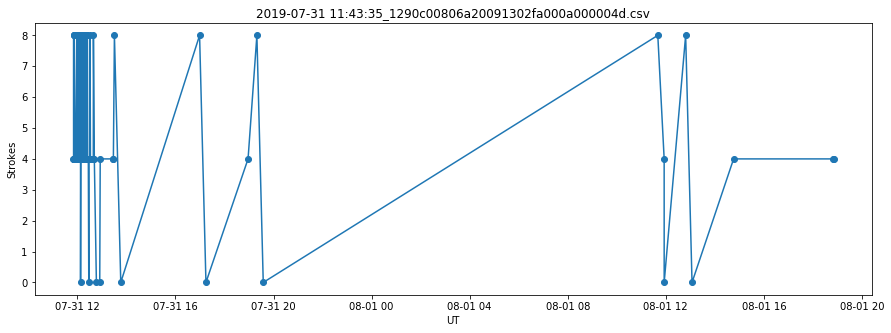

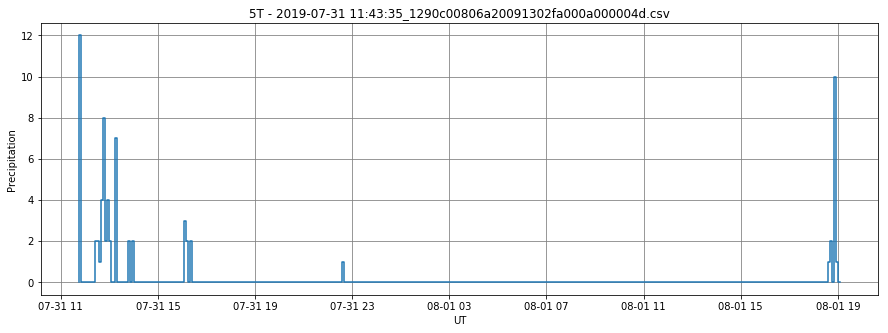

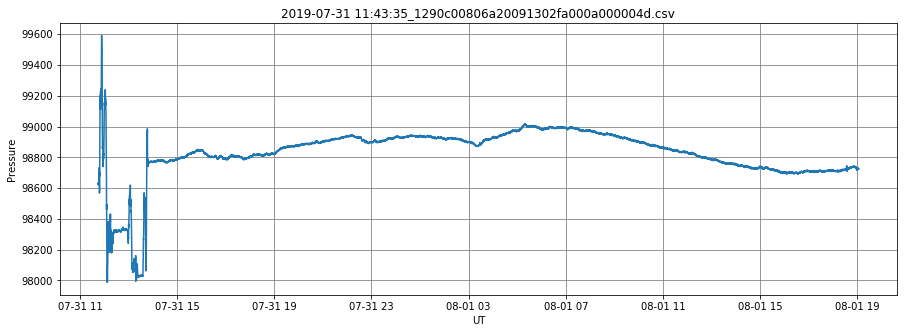

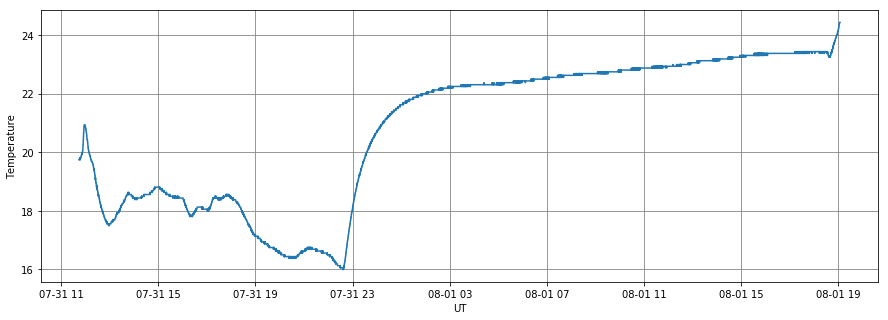

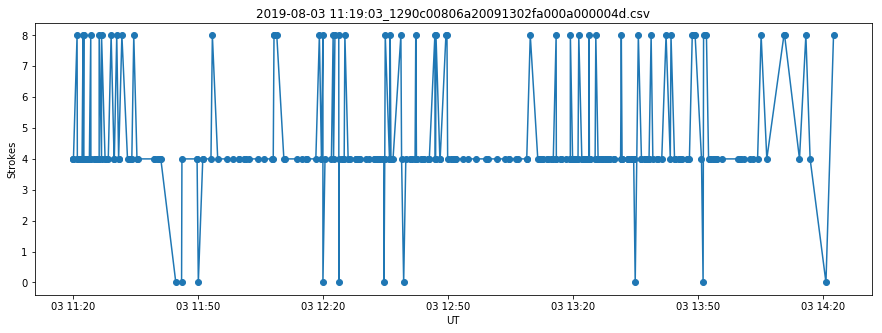

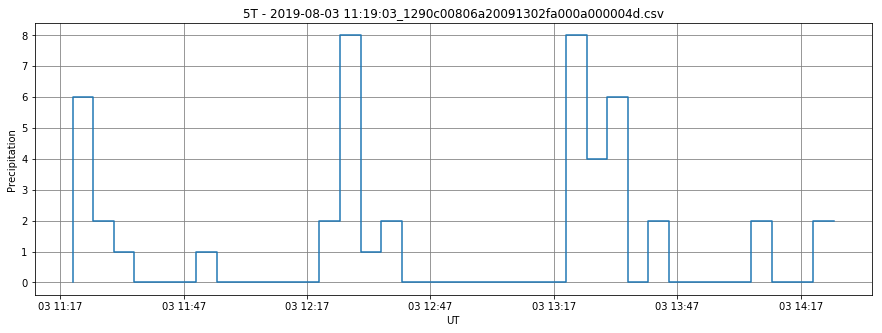

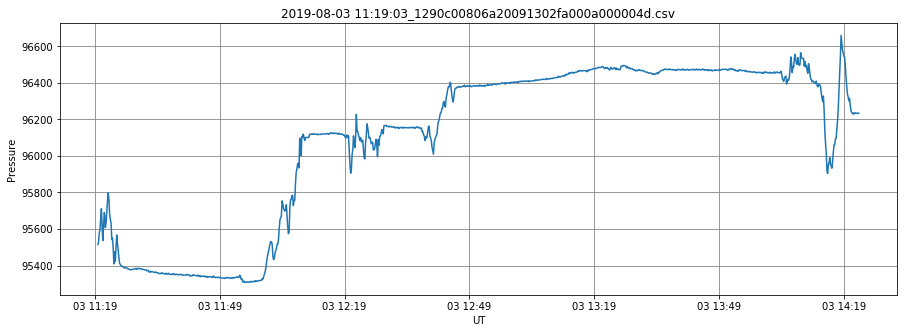

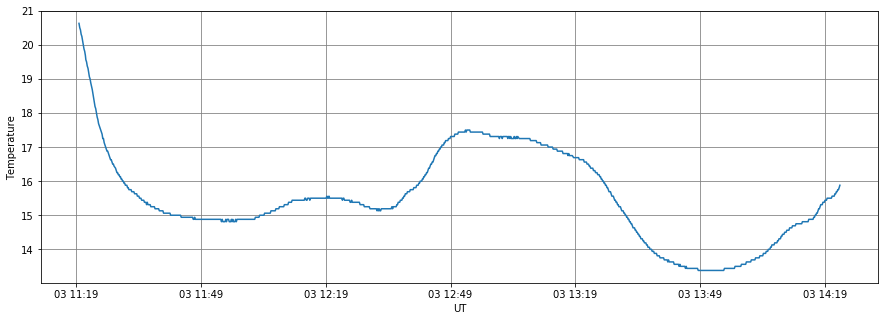

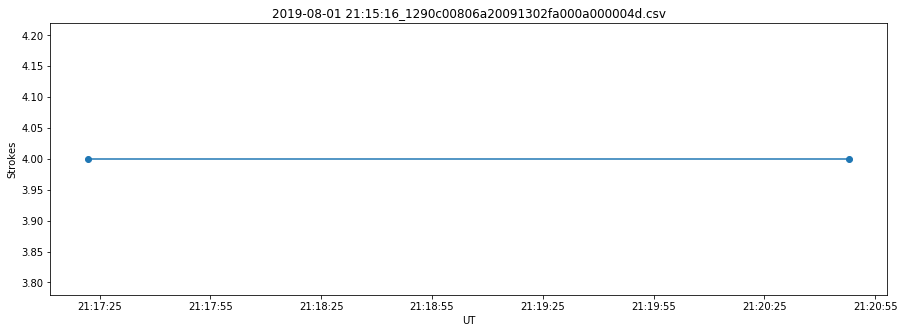

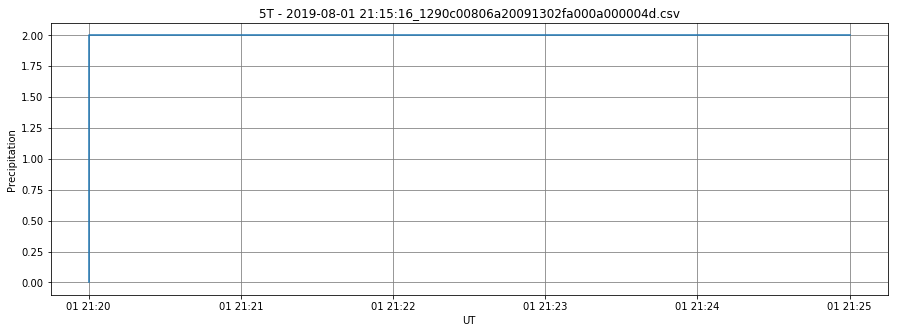

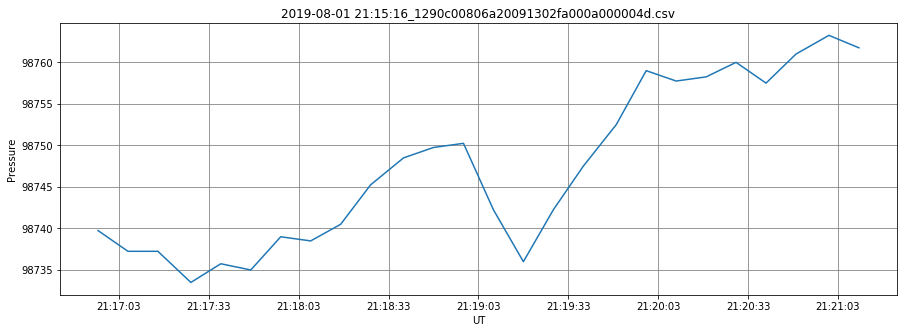

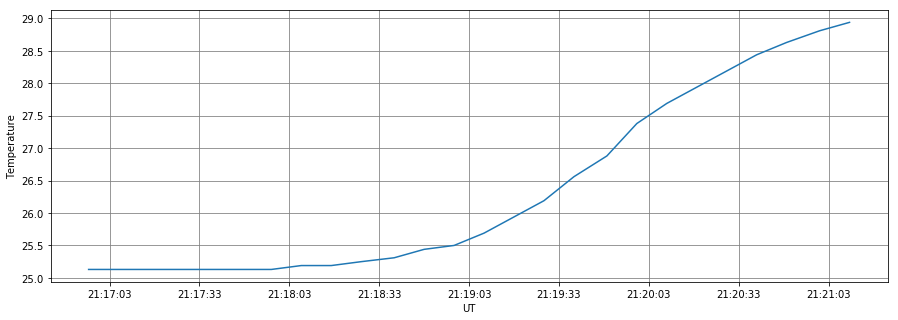

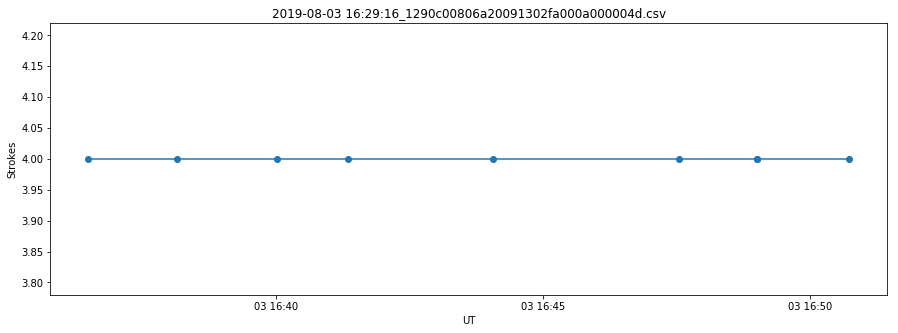

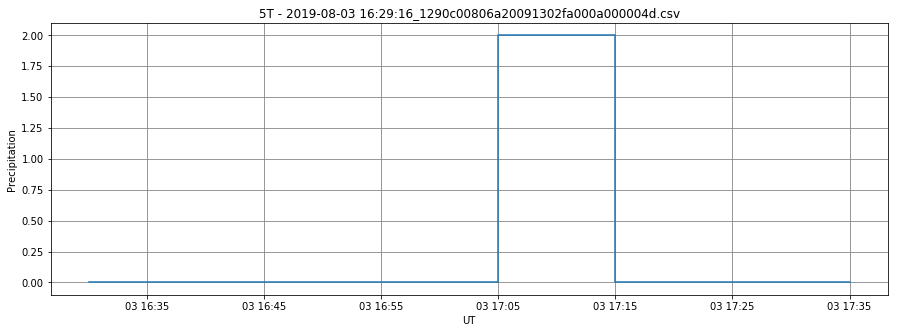

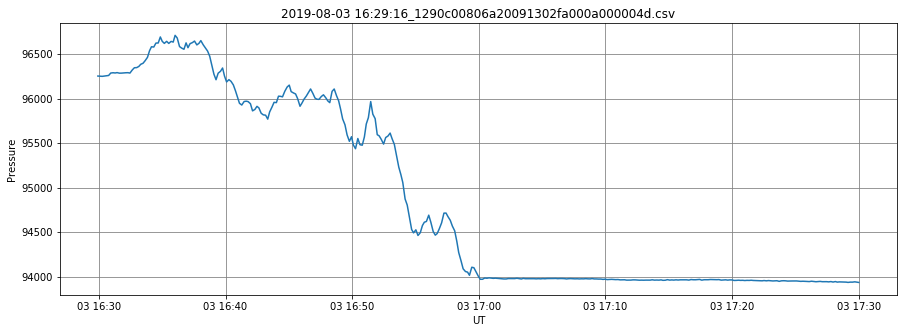

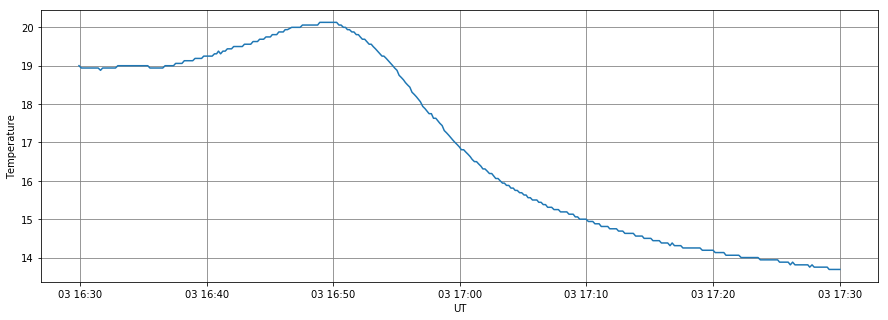

In [4]:
for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        s = f.split('/')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$MPL'].index, inplace=True)
        xx['12'] = pd.to_numeric(xx['12'])
        
        plt.figure(figsize=(15,5))
        plt.plot(xx['12'], marker='o')
        plt.title(s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Strokes')

        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['3'] = pd.to_numeric(xx['3'])

        interval = '5T'
        xx = xx.resample(interval, label='right').sum()
        plt.figure(figsize=(15,5))
        #plt.tight_layout()
        plt.plot(xx['3'], drawstyle='steps-pre')
        plt.title(interval + ' - ' + s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Precipitation')
        plt.grid(b=True, which='major', color='grey', linestyle='-')
        
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        xx.drop(xx[xx['0']=='$STROKE'].index, inplace=True)
        xx['4'] = pd.to_numeric(xx['4'])
        xx['5'] = pd.to_numeric(xx['5'])

        plt.figure(figsize=(15,5))
        plt.plot(xx['4'])
        #plt.locator_params(axis='y', nbins=6)
        plt.grid(b=True, which='major', color='grey', linestyle='-')

        plt.title(s[len(s)-1])
        plt.xlabel('UT')
        plt.ylabel('Pressure')
        #plt.legend(loc=2)

        #ax = plt.twinx()
        plt.figure(figsize=(15,5))                                         
        plt.plot(xx['5'])
        plt.xlabel('UT')
        plt.ylabel('Temperature')
        #plt.autoscale()       
        plt.grid(b=True, which='major', color='grey', linestyle='-')
        #plt.grid(b=True, which='minor', color='grey', linestyle='-')
        #plt.legend()
                
    except:
        pass



# Plot Map

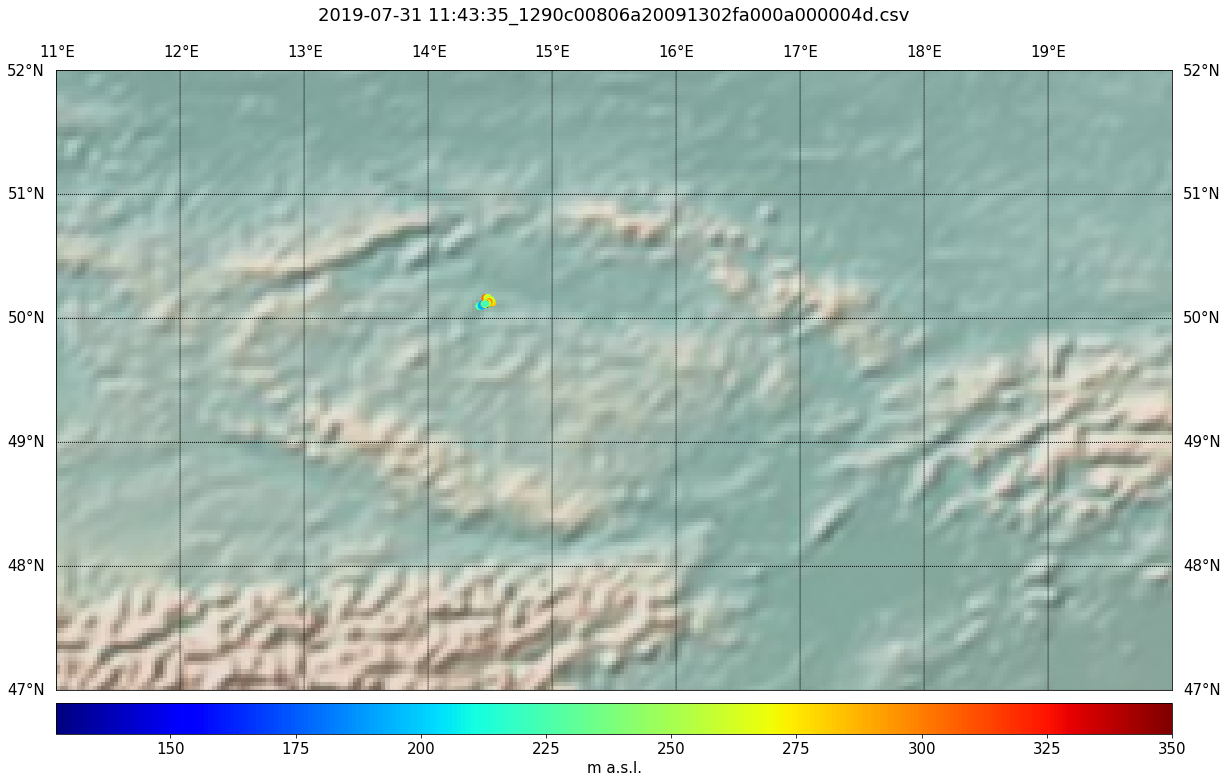

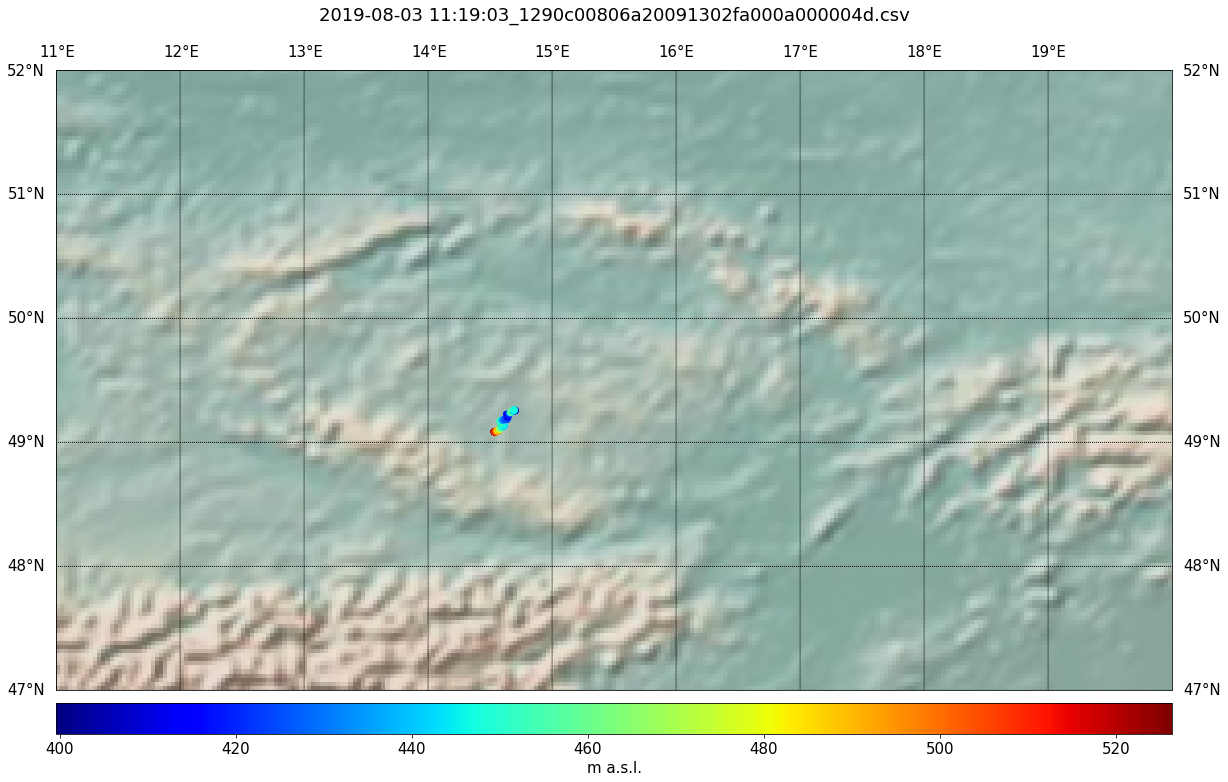

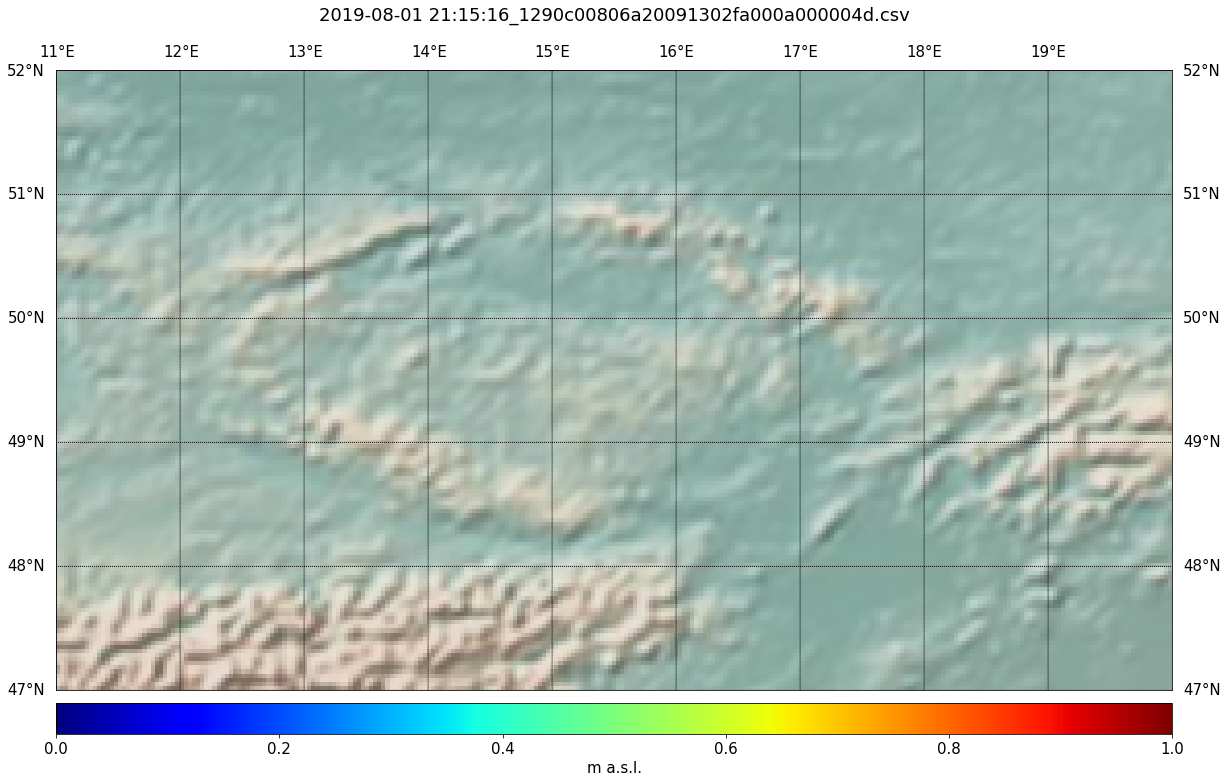

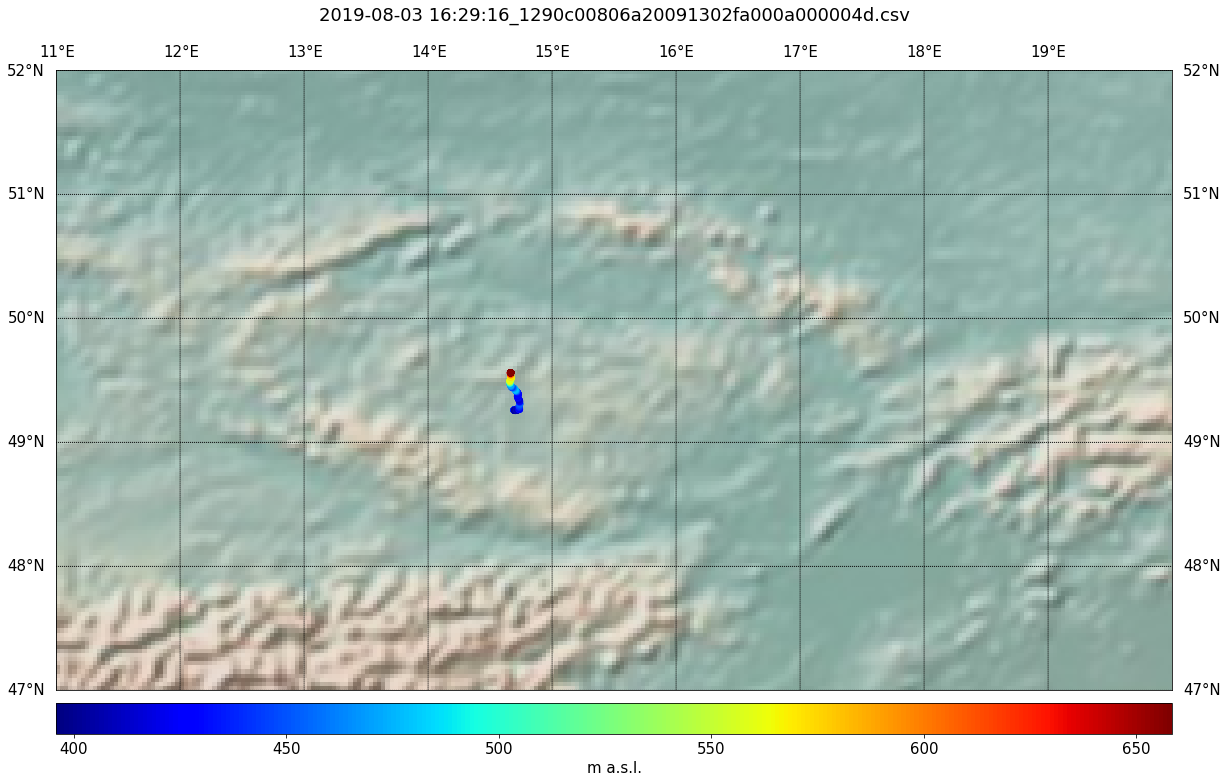

In [5]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(20,20))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
        #m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        #m.drawmapboundary(fill_color='#99ffff')
        #m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
        m.shadedrelief()
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        #plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


## Plot Street Map

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1591868.71834,6242595.99995,1669792.3619,6327621.18643&bboxSR=3395&imageSR=3395&size=700,763&dpi=96&format=png32&transparent=true&f=image


<Figure size 720x720 with 0 Axes>

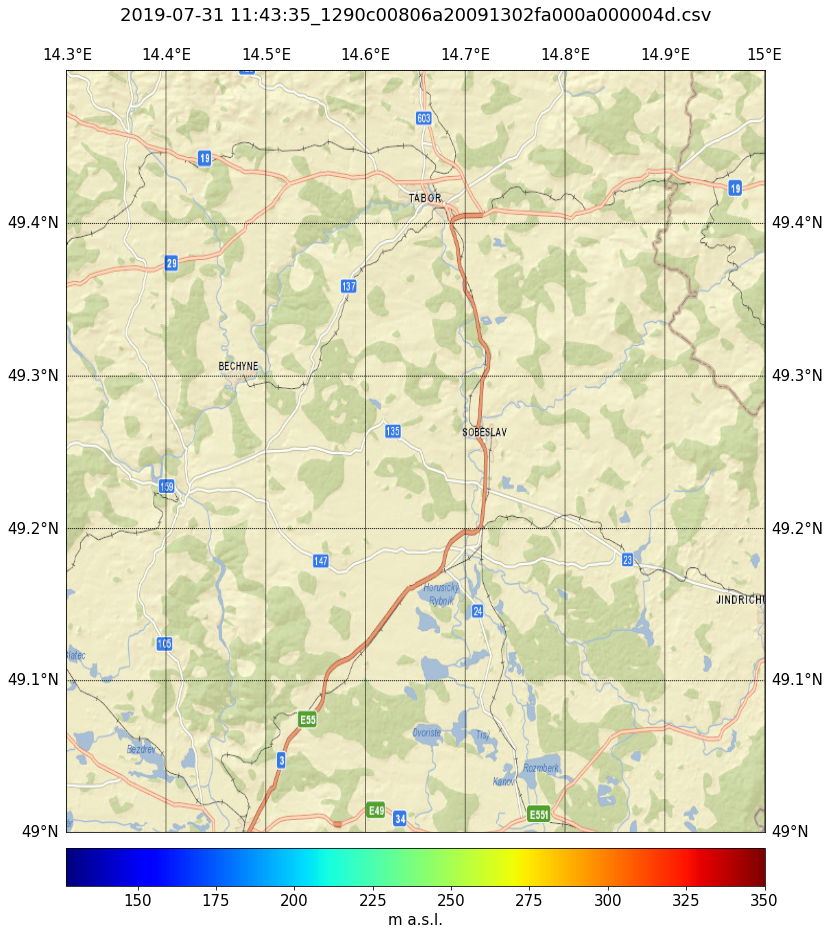

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1591868.71834,6242595.99995,1669792.3619,6327621.18643&bboxSR=3395&imageSR=3395&size=700,763&dpi=96&format=png32&transparent=true&f=image


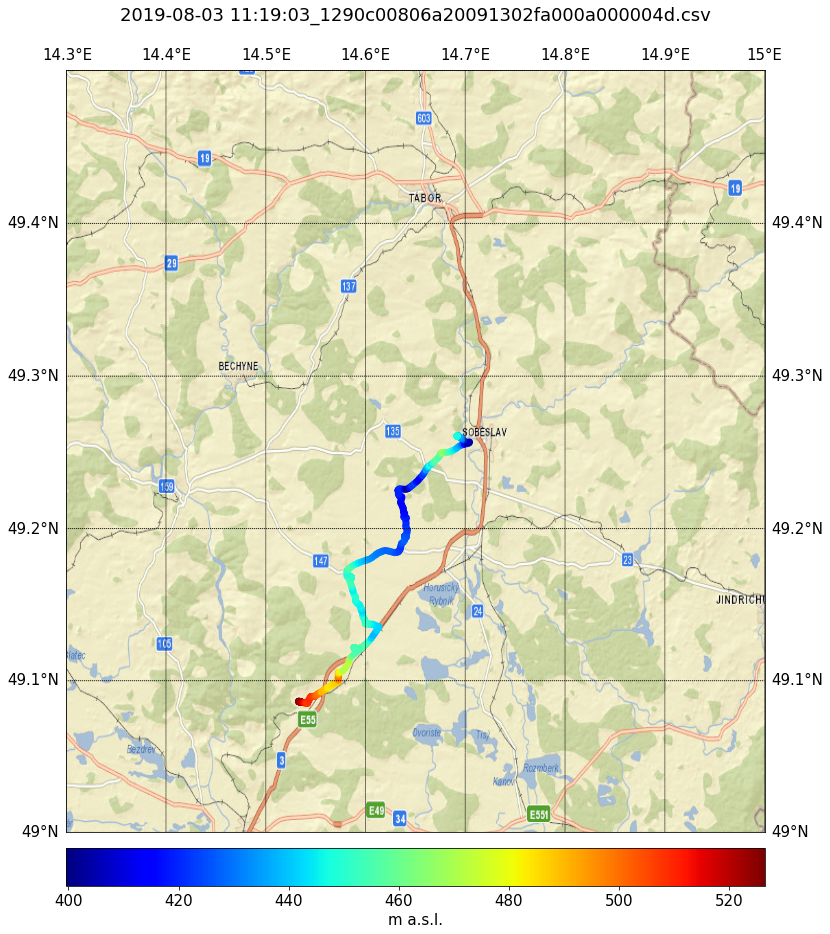

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1591868.71834,6242595.99995,1669792.3619,6327621.18643&bboxSR=3395&imageSR=3395&size=700,763&dpi=96&format=png32&transparent=true&f=image


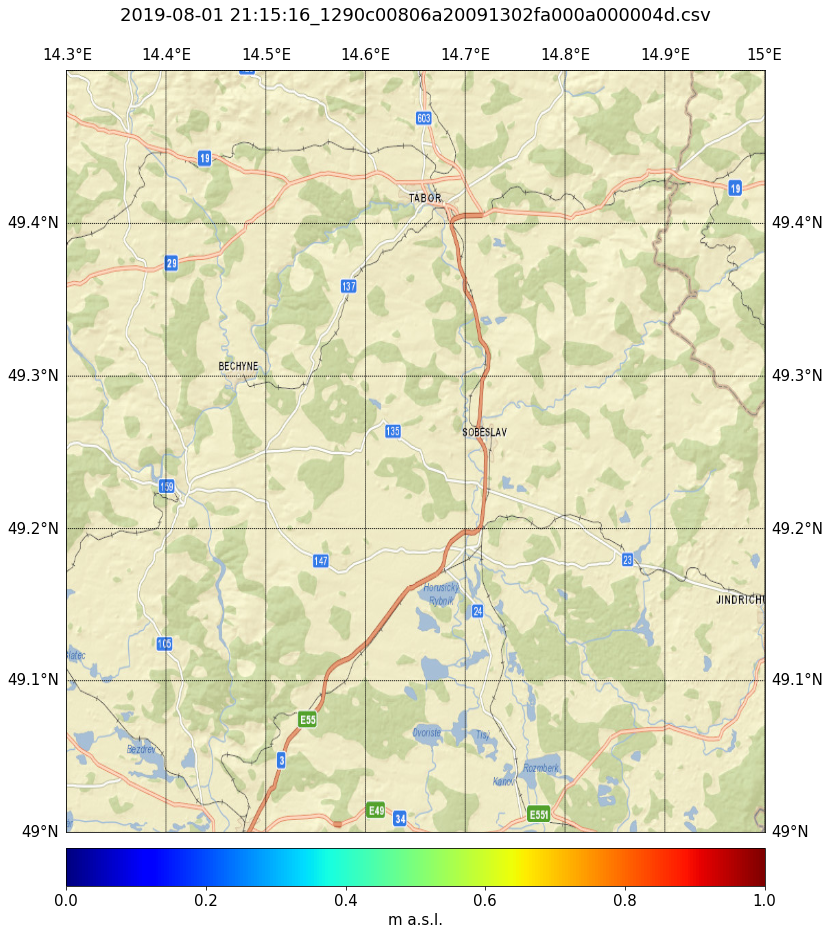

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1591868.71834,6242595.99995,1669792.3619,6327621.18643&bboxSR=3395&imageSR=3395&size=700,763&dpi=96&format=png32&transparent=true&f=image


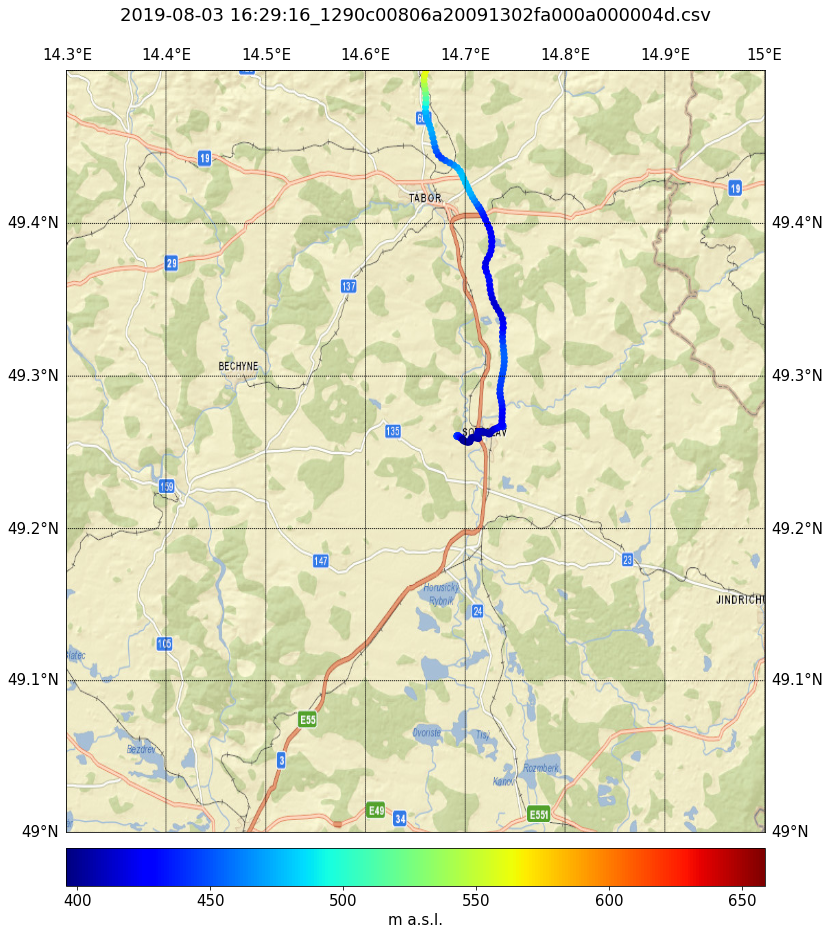

In [6]:
plt.figure(figsize=(10,10))

import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,15))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        #df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
               
        matplotlib.rcParams.update({'font.size': 15})

        m = Basemap(llcrnrlon=14.3,llcrnrlat=49,urcrnrlon=15, urcrnrlat=49.5,  epsg = 3395,resolution='i',projection='merc')
        #m = Basemap(llcrnrlon=15.25,llcrnrlat=50.1,urcrnrlon=15.5, urcrnrlat=50.2, epsg = 31284)
 
        m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 700, verbose= True)

        x, y = m(df6.lon.tolist(),df6.lat.tolist())

        m.drawparallels(np.arange(0.,99.,0.1),labels=[1,1,0,0])
        m.drawmeridians(np.arange(0.,20.,0.1),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.show() 
    except:
        pass


## Read log mlynek

In [72]:
fto = './data/DATALOG.TXT' #  File to Open

print fto

#l.extend(range(0,261))
df = pd.read_table(fto, sep=',', header=None, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$TIME'].index, inplace=True)
#df.drop(df[df[0]=='$STROKE'].index, inplace=True)
#df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
#df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
#df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)



./data/DATALOG.TXT


<IPython.core.display.Javascript object>


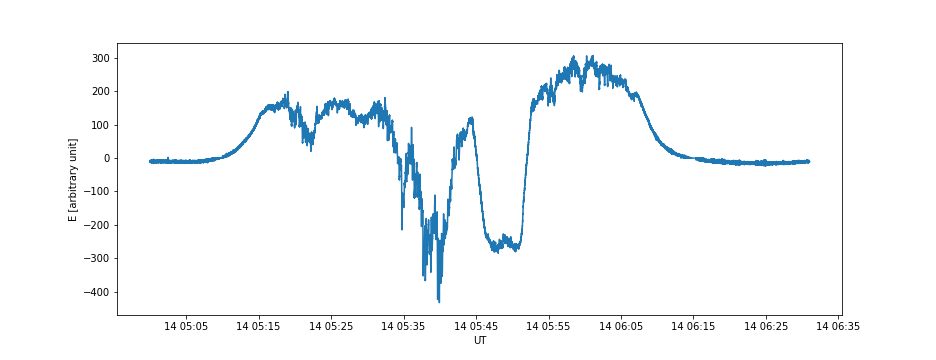

In [87]:
%matplotlib notebook

df['time'] = pd.to_datetime(pd.to_datetime('2019-07-12 14:40') + pd.to_timedelta(df.index*0.1133846790509479, unit='s'))

rc = df
rc = rc.set_index(['time'])

rc = rc.loc['2019-07-14 5:00':'2019-07-14 6:30']

plt.figure(figsize=(13,5))
plt.plot(rc[2])
#plt.locator_params(axis='x',nbins=40)
plt.xlabel('UT')
plt.ylabel('E [arbitrary unit]')

plt.show()

In [206]:
df6.loc[df6['lat']>49.194991].loc[df6['lat']<49.194992].loc[df6['lon']>14.63983].loc[df6['lon']<14.63984]


date        0    1     2     3         4      5     6  \
678   2019-08-03 12:49:01     $MPL  527  5394     0  96386.25  17.31   NaN   
679   2019-08-03 12:49:11     $MPL  528  5404     0  96384.50  17.31   NaN   
688   2019-08-03 12:50:12     $MPL  534  5465     0  96386.00  17.38   NaN   
689   2019-08-03 12:50:22     $MPL  535  5475     0  96383.00  17.38   NaN   
690   2019-08-03 12:50:32     $MPL  536  5485     0  96381.50  17.38   NaN   
691   2019-08-03 12:50:37  $STROKE  157  5490  0x1C      0x22   0xC2  0x04   
692   2019-08-03 12:50:43     $MPL  537  5496     0  96385.25  17.38   NaN   
698   2019-08-03 12:51:33     $MPL  542  5546     0  96387.00  17.44   NaN   
728   2019-08-03 12:55:38     $MPL  566  5791     0  96392.00  17.44   NaN   
737   2019-08-03 12:56:59     $MPL  574  5872     0  96398.75  17.38   NaN   
782   2019-08-03 13:03:58     $MPL  615  6291     0  96410.50  17.25   NaN   
783   2019-08-03 13:04:08     $MPL  616  6301     0  96410.50  17.25   NaN   
810   2019-08-03 13:07:52     $MPL  638  6525     0  96422.50  17.25   NaN   
815   2019-08-03 13:08:43     $MPL  643  6576     0  96426.00  17.19   NaN   
827   2019-08-03 13:10:15     $MPL  652  6668     0  96430.00  17.13   NaN   
877   2019-08-03 13:16:53     $MPL  691  7066     0  96466.50  16.81   NaN   
894   2019-08-03 13:18:45     $MPL  702  7178     0  96478.75  16.69   NaN   
896   2019-08-03 13:19:06     $MPL  704  7199     0  96477.25  16.69   NaN   
936   2019-08-03 13:23:21     $MPL  729  7454     0  96477.25  16.31   NaN   
950   2019-08-03 13:24:22     $MPL  735  7515     0  96481.25  16.19   NaN   
989   2019-08-03 13:28:20  $STROKE  233  7753  0x1C      0x22   0xC2  0x04   
990   2019-08-03 13:28:27     $MPL  759  7760     0  96471.00  15.44   NaN   
1025  2019-08-03 13:33:02     $MPL  786  8035     0  96448.00  14.63   NaN   
1031  2019-08-03 13:33:33     $MPL  789  8066     0  96448.75  14.56   NaN   
1032  2019-08-03 13:33:43     $MPL  790  8076     2  96448.75  14.50   NaN   
1033  2019-08-03 13:33:47  $STROKE  245  8080  0x1C      0x22   0xC2  0x04   
1034  2019-08-03 13:33:53     $MPL  791  8086     0  96452.25  14.50   NaN   
1036  2019-08-03 13:34:14     $MPL  793  8107     0  96449.25  14.44   NaN   
1037  2019-08-03 13:34:17  $STROKE  246  8110  0x1C      0x22   0xC2  0x04   
1038  2019-08-03 13:34:24     $MPL  794  8117     0  96457.75  14.38   NaN   
1043  2019-08-03 13:34:45     $MPL  796  8138     0  96461.75  14.31   NaN   
1083  2019-08-03 13:39:31     $MPL  824  8424     0  96472.25  13.75   NaN   
1099  2019-08-03 13:41:44     $MPL  837  8557     0  96469.75  13.63   NaN   
1103  2019-08-03 13:42:18  $STROKE  265  8591  0x1C      0x22   0xC2  0x08   
1104  2019-08-03 13:42:24     $MPL  841  8597     0  96473.00  13.63   NaN   
1105  2019-08-03 13:42:35     $MPL  842  8608     0  96475.00  13.63   NaN   
1123  2019-08-03 13:44:47     $MPL  855  8740     0  96470.50  13.50   NaN   
1125  2019-08-03 13:45:08     $MPL  857  8761     0  96475.00  13.50   NaN   
1143  2019-08-03 13:47:26  $STROKE  275  8899  0x1C      0x22   0xC2  0x04   
1144  2019-08-03 13:47:27  $STROKE  276  8900  0x1C      0x22   0xC2  0x04   
1145  2019-08-03 13:47:30     $MPL  871  8903     0  96466.75  13.44   NaN   
1148  2019-08-03 13:47:54  $STROKE  277  8927  0x1C      0x22   0xC2  0x04   
1149  2019-08-03 13:48:01     $MPL  874  8934     0  96472.25  13.44   NaN   
1155  2019-08-03 13:48:52     $MPL  879  8985     0  96470.00  13.38   NaN   
1178  2019-08-03 13:51:56     $MPL  897  9169     0  96477.00  13.38   NaN   
1181  2019-08-03 13:52:16     $MPL  899  9189     0  96473.50  13.38   NaN   
1182  2019-08-03 13:52:26     $MPL  900  9199     0  96473.75  13.38   NaN   
1183  2019-08-03 13:52:30  $STROKE  285  9203  0x1C      0x22   0xC2  0x04   
1184  2019-08-03 13:52:37     $MPL  901  9210     0  96474.25  13.38   NaN   

         7     8    ...      15  16  17  18  19  altitude  speed  run  \
678    NaN   NaN    ...     NaN NaN NaN NaN NaN